In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, GlobalAveragePooling1D, Reshape, multiply, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.ticker as ticker
import seaborn as sns

In [40]:
# Load data
data = pd.read_csv('Raw Dataset/train_data.csv')

data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])
data.sort_values('BaseDateTime', inplace=True)

print(data.head())


       Unnamed: 0.1  Unnamed: 0       MMSI        BaseDateTime       LAT  \
0           1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
3422        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
5019        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
7525        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
10762       1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   

            LON   SOG   COG  Heading      VesselName         IMO CallSign  \
0     -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
3422  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
5019  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
7525  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
10762 -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   

       VesselType  Status  Length  Width  Draft  Cargo TransceiverClass  
0     

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179647 entries, 0 to 179642
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0.1      179647 non-null  int64         
 1   Unnamed: 0        179647 non-null  int64         
 2   MMSI              179647 non-null  int64         
 3   BaseDateTime      179647 non-null  datetime64[ns]
 4   LAT               179647 non-null  float64       
 5   LON               179647 non-null  float64       
 6   SOG               179647 non-null  float64       
 7   COG               179647 non-null  float64       
 8   Heading           179647 non-null  float64       
 9   VesselName        179647 non-null  object        
 10  IMO               179647 non-null  object        
 11  CallSign          179647 non-null  object        
 12  VesselType        179647 non-null  float64       
 13  Status            179647 non-null  float64       
 14  Length   

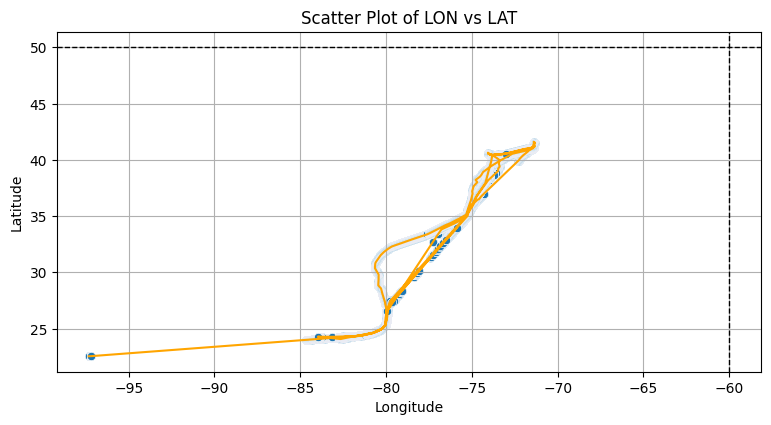

In [42]:
# Create the figure and subplot
plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 3)

# Plot the scatter points
sns.scatterplot(x='LON', y='LAT', data=data)
plt.title('Scatter Plot of LON vs LAT')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add lines connecting the points
plt.plot(data['LON'], data['LAT'], linestyle='-', color='orange')  # Draw straight lines between points

# Add Cartesian grid lines
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0 (x-axis)
plt.axvline(x=-60, color='black', linestyle='--', linewidth=1)  # Vertical line at x=0 (y-axis)
plt.grid(True)  # Enable the grid

# Show the plot
plt.show()

In [43]:
# Feature scaling
scalers = {col: MinMaxScaler() for col in ['LAT', 'LON', 'SOG', 'COG']}
for col, scaler in scalers.items():
    data[[col]] = scaler.fit_transform(data[[col]])
    

In [44]:
# Create sequences for training
SEQ_LENGTH = 10

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length]
        label = data.iloc[i+seq_length]
        sequences.append((seq[['LAT', 'LON', 'SOG', 'COG']].values, label[['LAT', 'LON']].values))
    return sequences

sequences = create_sequences(data, SEQ_LENGTH)

# Split data into features and labels
X, y = zip(*sequences)
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

# Ensure Correct Data Types
X = X.astype(np.float32)
y = y.astype(np.float32)

#Split the data into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [45]:
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x


def build_model(seq_length, embedding_dim):
    input_seq = Input(shape=(seq_length, 4), name='input_seq')

    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_seq)
    x = squeeze_excite_block(x)
    x = GlobalAveragePooling1D()(x)

    # LSTM layers
    lstm_out = LSTM(64)(Lambda(lambda x: tf.expand_dims(x, axis=1))(x))  # Wrap tf.expand_dims

    # Fully connected layers
    output = Dense(2)(lstm_out)

    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


In [46]:
# Initialize KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
mae_per_fold = []
r2_per_fold = []

In [47]:
# Cross-validation loop on the training set (X_train_full, y_train_full)
for train_index, val_index in kf.split(X_train_full):
    print(f"Training fold {fold_no}...")

    # 3. Split data into training and validation for this fold
    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # 4. Build the model
    model = build_model(SEQ_LENGTH, 4)  # Adjust 'build_model' to match your architecture

    # 5. Define callbacks (early stopping and learning rate reduction)
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # 6. Train the model on this fold's training data
    history = model.fit(
        X_train, y_train, epochs=20, batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )

    # 7. Evaluate the model on the validation set for this fold
    y_val_pred = model.predict(X_val)

    # 8. Inverse transform predictions and actual values (adjust according to your scalers)
    y_val[:, 0] = scalers['LAT'].inverse_transform(y_val[:, 0].reshape(-1, 1)).reshape(-1)
    y_val[:, 1] = scalers['LON'].inverse_transform(y_val[:, 1].reshape(-1, 1)).reshape(-1)
    y_val_pred[:, 0] = scalers['LAT'].inverse_transform(y_val_pred[:, 0].reshape(-1, 1)).reshape(-1)
    y_val_pred[:, 1] = scalers['LON'].inverse_transform(y_val_pred[:, 1].reshape(-1, 1)).reshape(-1)

    # 9. Calculate metrics (Mean Absolute Error and R^2 score)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    print(f"Fold {fold_no} MAE: {mae}, R^2: {r2}")

    # 10. Store the results for this fold
    mae_per_fold.append(mae)
    r2_per_fold.append(r2)

    fold_no += 1

    # Print average results
print("Evaluating on test set...")
y_test_pred = model.predict(X_test)

Training fold 1...
Epoch 1/20
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0198 - mae: 0.0440 - val_loss: 7.3787e-06 - val_mae: 0.0017 - learning_rate: 0.0010
Epoch 2/20
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.1696e-05 - mae: 0.0015 - val_loss: 2.5164e-06 - val_mae: 7.5812e-04 - learning_rate: 0.0010
Epoch 3/20
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.5970e-05 - mae: 0.0017 - val_loss: 1.1757e-05 - val_mae: 0.0031 - learning_rate: 0.0010
Epoch 4/20
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.3375e-05 - mae: 0.0015 - val_loss: 9.9205e-06 - val_mae: 0.0021 - learning_rate: 0.0010
Epoch 5/20
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.2875e-05 - mae: 0.0013 - val_loss: 2.6236e-06 - val_mae: 8.6854e-04 - learning_rate: 0.0010
Epoch 6/20
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 8.7395e-06 - mae: 0.0011 - val_loss: 3.2196e-06 - val_mae: 0.0012 - learning_rate: 0.0010
Epoch 7/20
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 7.5

In [48]:
# Inverse transform predictions and actual values for the test set
y_test[:, 0] = scalers['LAT'].inverse_transform(y_test[:, 0].reshape(-1, 1)).reshape(-1)
y_test[:, 1] = scalers['LON'].inverse_transform(y_test[:, 1].reshape(-1, 1)).reshape(-1)
y_test_pred[:, 0] = scalers['LAT'].inverse_transform(y_test_pred[:, 0].reshape(-1, 1)).reshape(-1)
y_test_pred[:, 1] = scalers['LON'].inverse_transform(y_test_pred[:, 1].reshape(-1, 1)).reshape(-1)

# 13. Calculate final metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set MAE: {mae_test}, Test Set R^2: {r2_test}")

Test Set MAE: 0.006393409334123135, Test Set R^2: 0.9996880292892456


In [49]:
# Print average results
print(f"\nAverage MAE across folds: {np.mean(mae_per_fold)}")
print(f"Average R^2 across folds: {np.mean(r2_per_fold)}")


Average MAE across folds: 0.00512638920918107
Average R^2 across folds: 0.999834406375885


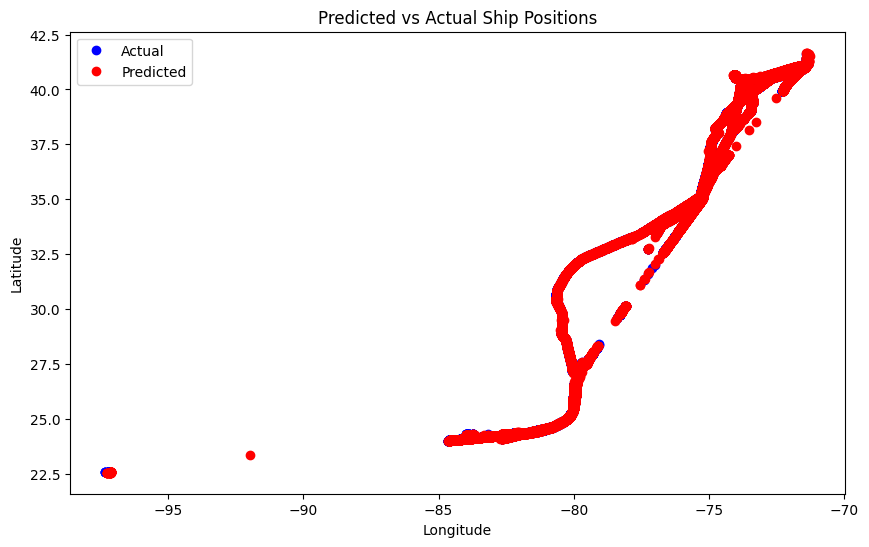

In [50]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 1], y_test[:, 0], 'bo', label='Actual')   # y_test[:, 1] untuk Longitude, y_test[:, 0] untuk Latitude
plt.plot(y_test_pred[:, 1], y_test_pred[:, 0], 'ro', label='Predicted') # y_pred[:, 1] untuk Longitude, y_pred[:, 0] untuk Latitude
plt.xlabel('Longitude')  # Label untuk sumbu x
plt.ylabel('Latitude')   # Label untuk sumbu y
plt.legend()
plt.title('Predicted vs Actual Ship Positions')
plt.show()


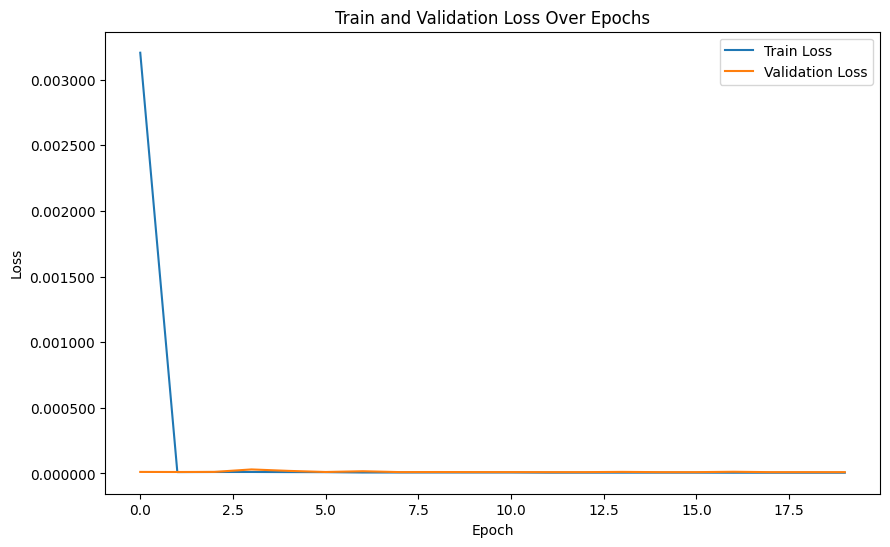

In [51]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()


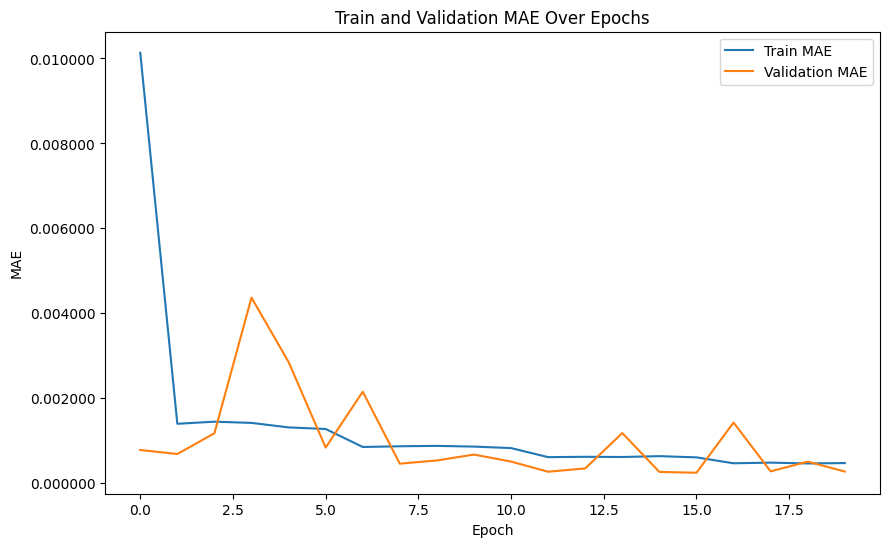

In [52]:
# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Train and Validation MAE Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()

In [53]:
def predict_next_position(lat_manual, lon_manual, sog_manual, cog_manual, model, scalers, seq_length=10):
    """
    Memprediksi latitude dan longitude berikutnya berdasarkan input manual dan model yang dilatih.

    Args:
    lat_manual: Latitude yang diinput secara manual.
    lon_manual: Longitude yang diinput secara manual.
    sog_manual: Speed Over Ground (SOG) yang diinput secara manual.
    cog_manual: Course Over Ground (COG) yang diinput secara manual.
    model: Model CNN-LSTM yang sudah dilatih.
    scalers: Dictionary yang berisi scaler untuk setiap fitur (LAT, LON, SOG, COG).
    seq_length: Panjang sequence yang dibutuhkan model, default 10.

    Returns:
    Prediksi latitude dan longitude berikutnya.
    """
    # Buat input array berdasarkan input manual
    input_data = np.array([[lat_manual, lon_manual, sog_manual, cog_manual]])

    # Lakukan scaling sesuai skema sebelumnya
    input_data[:, 0] = scalers['LAT'].transform(input_data[:, 0].reshape(-1, 1)).reshape(-1)
    input_data[:, 1] = scalers['LON'].transform(input_data[:, 1].reshape(-1, 1)).reshape(-1)
    input_data[:, 2] = scalers['SOG'].transform(input_data[:, 2].reshape(-1, 1)).reshape(-1)
    input_data[:, 3] = scalers['COG'].transform(input_data[:, 3].reshape(-1, 1)).reshape(-1)

    # Buat sequence dengan panjang seq_length dengan menduplikasi input manual
    sequence_input = np.tile(input_data, (seq_length, 1))

    # Sesuaikan input dengan panjang sequence yang dibutuhkan model
    sequence_input = np.expand_dims(sequence_input, axis=0).astype(np.float32)

    # Lakukan prediksi
    predicted = model.predict(sequence_input)

    # Lakukan inverse scaling agar prediksi kembali ke skala asli
    predicted[:, 0] = scalers['LAT'].inverse_transform(predicted[:, 0].reshape(-1, 1)).reshape(-1)
    predicted[:, 1] = scalers['LON'].inverse_transform(predicted[:, 1].reshape(-1, 1)).reshape(-1)

    return predicted[0, 0], predicted[0, 1]

# Contoh penggunaan
lat_manual = 24.05323
lon_manual = -84.21892
sog_manual = 22.3
cog_manual = 82.8

predicted_lat, predicted_lon = predict_next_position(lat_manual, lon_manual, sog_manual, cog_manual, model, scalers)

print(f"Prediksi Latitude berikutnya: {predicted_lat}")
print(f"Prediksi Longitude berikutnya: {predicted_lon}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediksi Latitude berikutnya: 24.04880714416504
Prediksi Longitude berikutnya: -84.20550537109375


c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
